# Deep Neural Network Final Project
## Pot Hole Classification Program

Oscar Adrián Peña García - A01176808
Ian Pablo Granados Martín - A00818648

Program built to classify a group of images of streets, highways and roads into 2 groups, images that have potholes and the ones that don't. This program has real-life applications and can help in maintenance of a city's infrastructure. Images provided by Kaggle for educational purposes.

## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent

In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Dataset

The images are separated in train, dev, and test datasets.
Each dataset contains images of size 128x128 pixels of RGB data.
Images may contain an image of a road with one or multiple potholes, or without any.

#### Because we already passed testing stage, all references to dev are commented.

In [3]:
train_x_orig, train_y, test_x_orig, test_y, dev_x_orig, dev_y = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 1


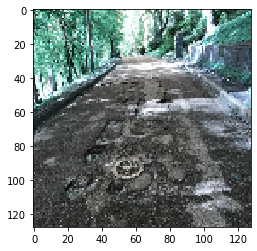

In [4]:
# Example of a picture
index = 12
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]))

In [6]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]
# m_dev = dev_x_orig.shape[0] NO LONGER USING DEV

print ("Number of training examples: " + str(m_train))
# print ("Number of developing examples: " + str(m_dev)) NO LONGER USING DEV
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
# print ("dev_x_orig shape: " + str(dev_x_orig.shape)) NO LONGER USING DEV
# print ("dev_y shape: " + str(dev_y.shape)) NO LONGER USING DEV
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 578
Number of testing examples: 102
Each image is of size: (128, 128, 3)
train_x_orig shape: (578, 128, 128, 3)
train_y shape: (1, 578)
test_x_orig shape: (102, 128, 128, 3)
test_y shape: (1, 102)


The following cell reshapes the X data, flattening it and normalizing it to values between 0 and 1.

In [7]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
# dev_x_flatten = dev_x_orig.reshape(dev_x_orig.shape[0], -1).T NO LONGER USING DEV

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
# dev_x = dev_x_flatten/255. NO LONGER USING DEV

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
# print ("dev_x's shape: " + str(dev_x.shape)) NO LONGER USING DEV


train_x's shape: (49152, 578)
test_x's shape: (49152, 102)


$49,152$ equals $128 \times 128 \times 3$ which is the size of one reshaped image vector.

## 3 - L-layer Neural Network

We used the code and functions given in prior homeworks to test different hyperparameters

```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

### 3.1- L-layer deep neural network

<u>Detailed Architecture</u>:
- The input is a (128,128,3) image which is flattened to a vector of size (49152,1).
- The corresponding vector: $[x_0,x_1,...,x_{49152}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a pothole.

### 3.2 - General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels


In [8]:
### CONSTANTS ###
layers_dims = [49152, 25, 20, 15, 1] #  4-layer model

In [9]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 2500, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_he(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

### The following cells show the costs of iteration after training the model. As well as the accuracys of both the training set and the testing set.

Cost after iteration 0: 1.850975
Cost after iteration 100: 0.492471
Cost after iteration 200: 0.515867
Cost after iteration 300: 0.375312
Cost after iteration 400: 0.829471
Cost after iteration 500: 0.323550
Cost after iteration 600: 0.273729
Cost after iteration 700: 0.349437
Cost after iteration 800: 0.365491
Cost after iteration 900: 0.133317
Cost after iteration 1000: 0.183951
Cost after iteration 1100: 0.133319
Cost after iteration 1200: 0.142310
Cost after iteration 1300: 0.118500
Cost after iteration 1400: 0.212740
Cost after iteration 1500: 0.216565
Cost after iteration 1600: 0.077864
Cost after iteration 1700: 0.069260


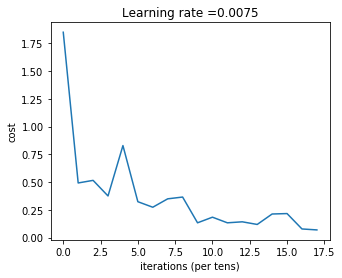

In [10]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1800, print_cost = True)

In [12]:
pred_train, train_error = predict(train_x, train_y, parameters) #[49152, 25, 1] #  2-layer model

Accuracy: 0.980968858131488


In [13]:
pred_test, test_error = predict(test_x, test_y, parameters)

Accuracy: 0.8431372549019605


In [14]:
print("Bias: " + str(train_error))
print("Variance: " + str(test_error-train_error))

Bias: 0.019031141868511958
Variance: 0.1378316032295276


## 4 - Experiments done on database on development phase

<p>During our development phase, we tested on varying each hyperparameter, finding the best one, and then moving on to the next one</p>
<p>The order in wich we tested these hyper parameters was the following:</p>
<ul>
    <li>Learning rate</li>
    <li>Number of iterations</li>
    <li>Number of layers and neurons</li>
    <li>Activation functions</li>
    <li>Inizialization type</li>
</ul>
<p>Next are the tables of the results we found for each test</p>

<img src="images/learningrate.png" style="text-align: center; width: 600px;">
<caption><center> <u>Figure 1</u>: Results for learning rate tests</center></caption>

<img src="images/iterations.png" style="text-align: center; width: 600px;">
<caption><center> <u>Figure 2</u>: Results for number of iterations tests</center></caption>

<img src="images/architecture.png" style="text-align: center; width: 600px;">
<caption><center> <u>Figure 3</u>: Results for number of layers and neurons tests</center></caption>

<img src="images/activation.png" style="text-align: center; width: 600px;">
<caption><center> <u>Figure 4</u>: Results for learning activation function tests</center></caption>

<img src="images/initialization.png" style="text-align: center; width: 600px;">
<caption><center> <u>Figure 5</u>: Results for initialization type tests</center></caption>



##  5 - Results Analysis of Mislabeled Images

Let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

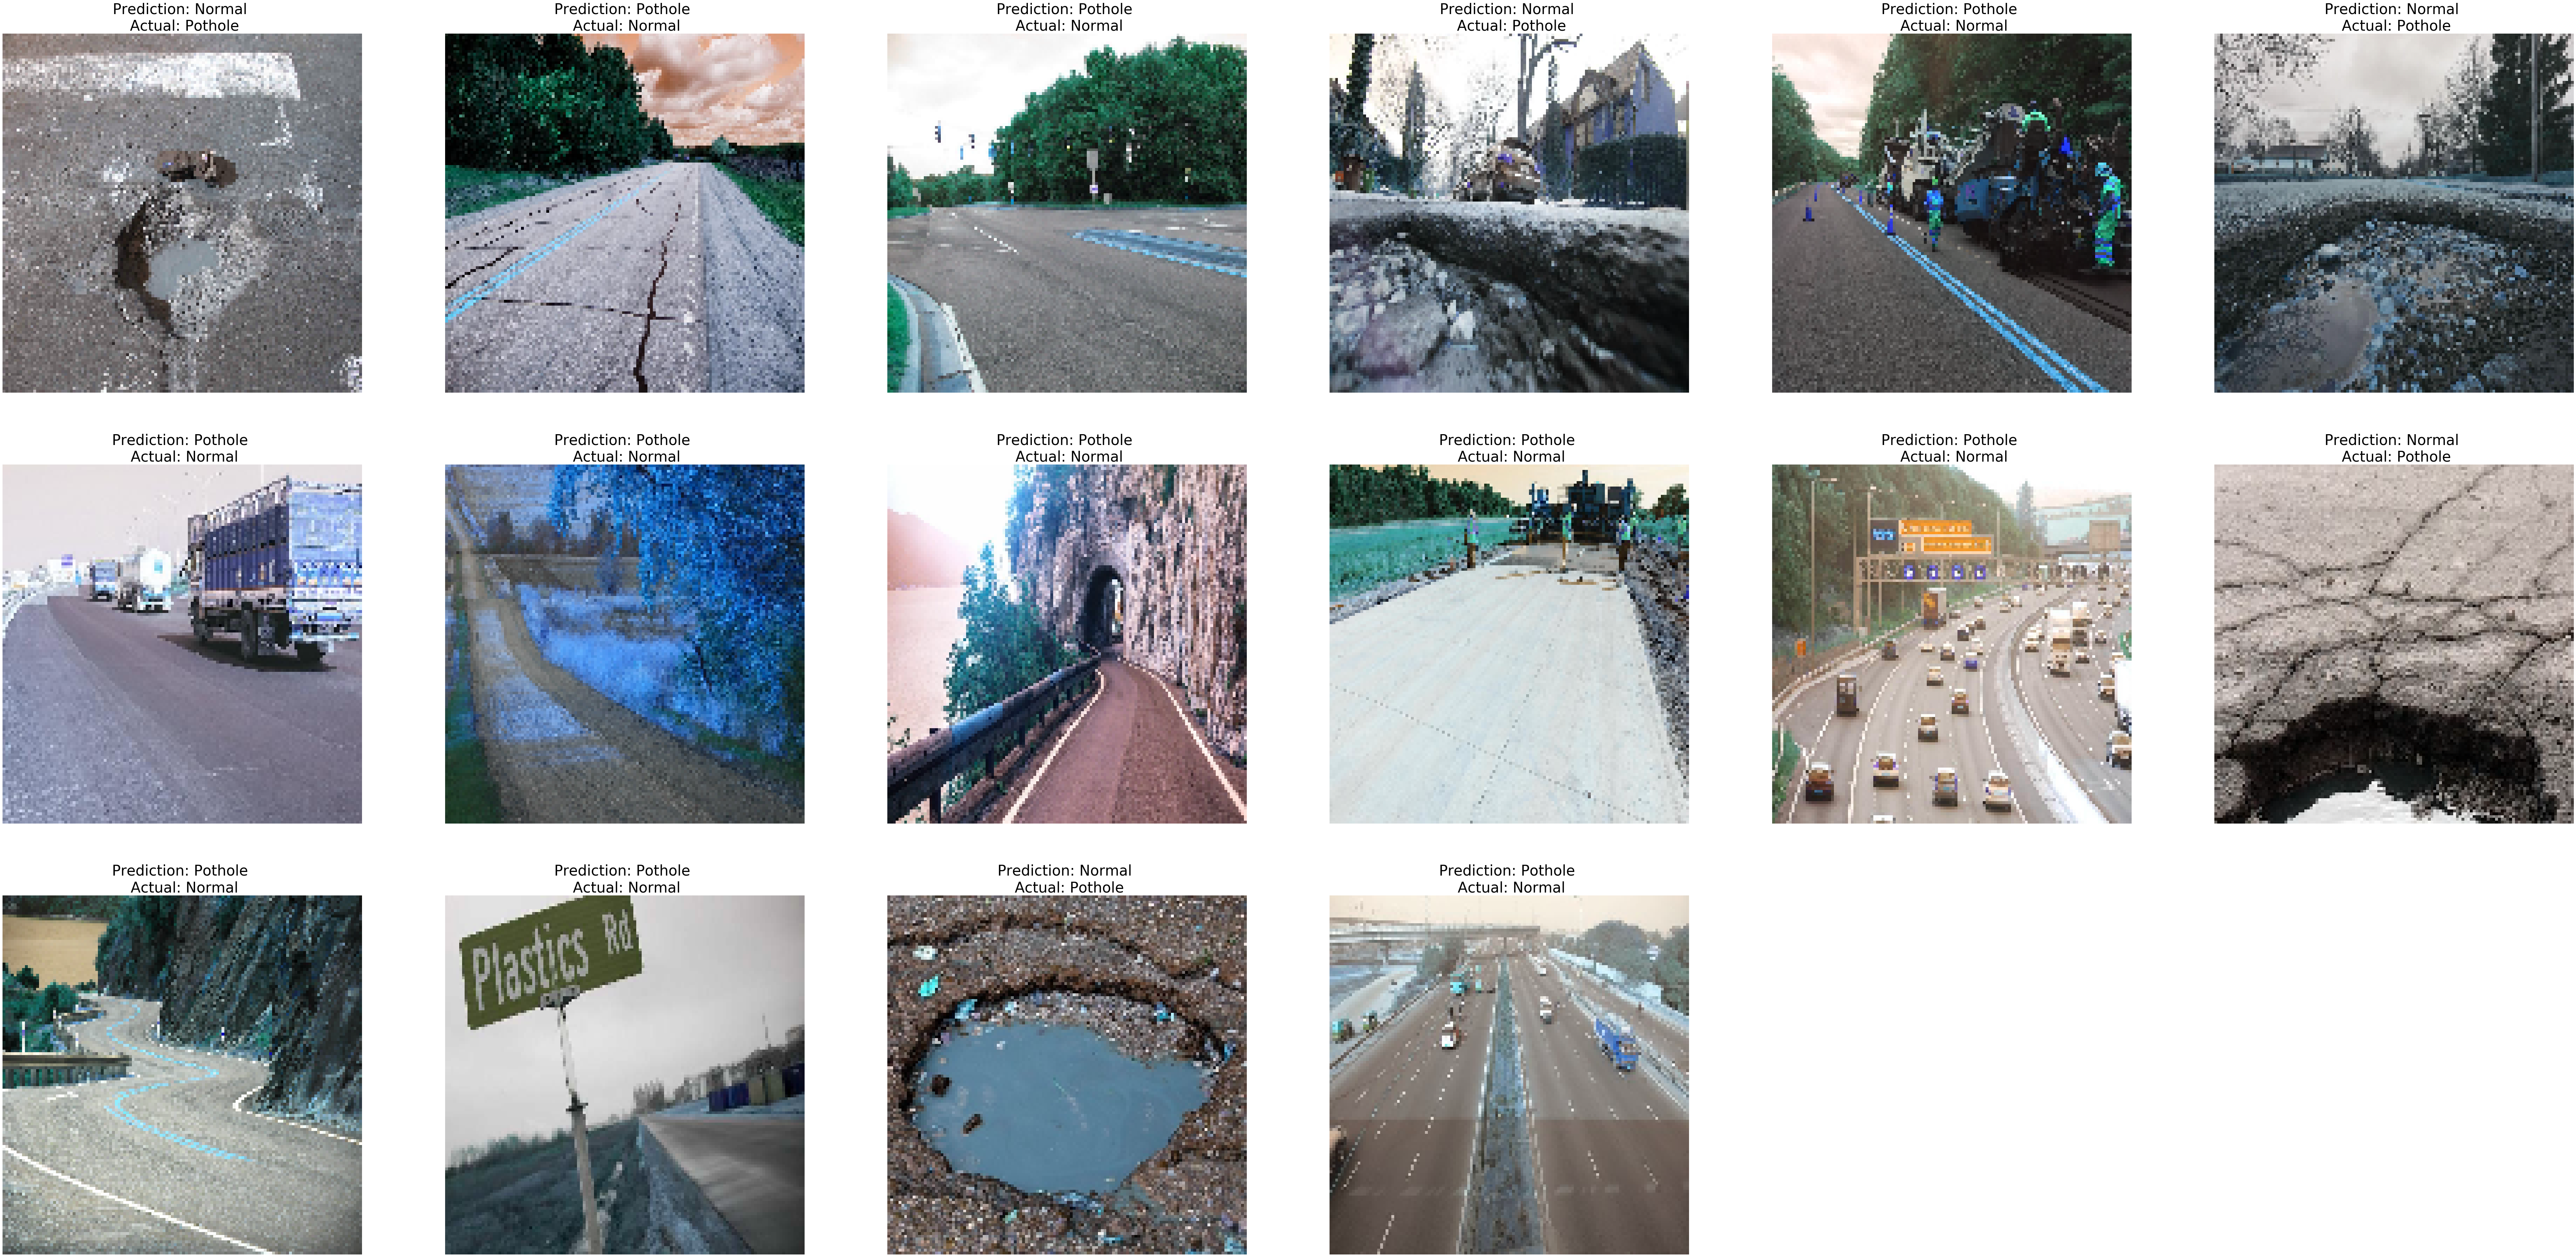

In [15]:
print_mislabeled_images(test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Images with water
- Images with little details
- Images of very close-up objests